# Modelos de regresión lineal

![BLR](https://upload.wikimedia.org/wikipedia/commons/e/ed/Bayes_icon.svg)

Hasta ahora hemos visto modelos de regresión lineal, usando inferencia exacta para la estimación de la distribución posterior de los parámetros, bajo un caso particular (suponiendo la varianza de la dispersión conocida). Si quisiéramos asumir previas distintas a la normal para los parámetros, incluyendo una previa para el parámetro de varianza, entonces la inferencia exacta de la distribución posterior se vuelve prácticamente imposible.

En este tema, estudiamos el uso de muestreo de la distribución posterior usando técnicas Montecarlo, dándonos la libertad de elegir la previa que mejor represente nuestro conocimiento de la situación.

> **Objetivos:**
> - Revisitar modelos de predicción lineal desde una perspectiva de Montecarlo.

> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

## 1. Predicción lineal

Lo que acabamos de ver es un modelo Gaussiano para la altura de una población de adultos. Sin embargo, este modelo no tiene el componente de *regresión*.

Es común que queramos modelar como el resultado de cierta variable se relaciona con otra(s) variable(s), llamada(s) **predictor(es)**. Si el predictor tiene alguna asociación estadística con la variable de interés, la podemos usar para *predecir* dicha variable.

En este caso estudiaremos como incluir estos predictores de forma lineal en el modelo. 

Seguiremos usando los datos de los adultos en la población, pero esta vez, veremos como la altura se relaciona con el peso:

In [1]:
# Importar pandas
import pandas as pd

In [2]:
# Leer datos (separados por ;)
datos_altura = pd.read_csv(
    "data/Howell1.csv", sep=";"
)

In [3]:
# Extraer datos de adultos
datos_altura_adultos = datos_altura[
    datos_altura["age"] >= 18
]

In [4]:
# Algunas filas
datos_altura_adultos.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [6]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Altura (cm)')

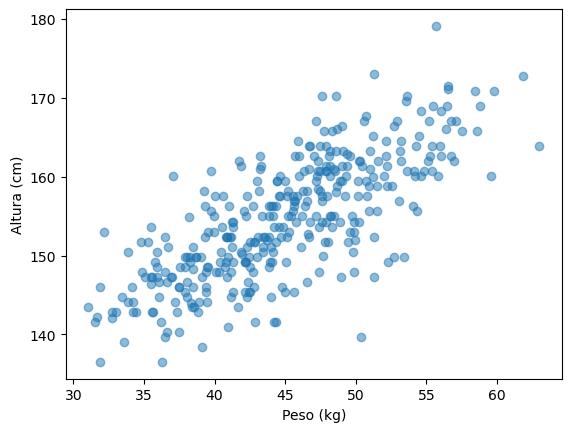

In [8]:
# Scatter plot
plt.scatter(
    datos_altura_adultos["weight"],
    datos_altura_adultos["height"],
    alpha=0.5
)
plt.xlabel("Peso (kg)")
plt.ylabel("Altura (cm)")

Del gráfico anterior, observamos que en definitiva hay una relación marcada entre la altura y el peso. Es decir, conocer el peso de una persona nos ayuda a predecir su altura.

**¿Cómo adecuamos el modelo de la altura para incluir el peso como predictor?**

La estrategia es modificar el parámetro $\mu$ de la distribución Gaussiana, para que sea una función lineal del predictor. Ahora, para los parámetros de esta función, tendremos que declarar distribuciones previas.

De forma que, teníamos:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu, \sigma) \\
\mu & \sim & \text{Normal}(170, 20) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

Ahora, sea $w_i$ el peso de la persona $i$ y sean $\bar{w}$ el promedio de todos los pesos. De esta forma:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta(w_i - \bar{w}) \\
\alpha & \sim & \text{Normal}(170, 20) \\
\beta & \sim & \text{Normal}(0, 10) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

*¿Qué significa esto?*

- Como antes, la primera expresión es la verosimilitud (probabilidad de los datos). Es casi la misma expresión, nada más notemos que cambiamos la media general $\mu$, por una media $\mu_i$ para cada observación. Es decir, la media depende de los valores específicos de cada observación.

- La segunda expresión, corresponde al modelo lineal. $\mu$ ya no es un parámetro que estimemos, sino una relación determinista (notar el símbolo $=$ en lugar de $\sim$) a los nuevos parámetros $\alpha$ y $\beta$, y que depende de la variable observada $w_i$.

  ¿Porqué incluir como predictor $w_i - \bar{w}$ en lugar de símplemente $w_i$? Algo importante cuando modelamos es poder entender los parámetros que estamos introduciendo. Notemos que de la manera en que especificamos el modelo $\mu=\alpha$ cuando $w_i=\bar{w}$; es decir, $\alpha$ es el valor esperado de la altura cuando el peso es promedio.

  ¿Y qué pasa con $\beta$? Bueno, pues el parámetro $\beta$ es el cambio esperado en la altura, cuando el peso cambia $1$ unidad (kg).

- Las demás expresiones, como antes, son las previas de nuestros parámetros, que deberemos ajustar con una debida simulación predictiva previa de ser necesario.

In [10]:
# Importart scipy.stats
from scipy import stats
# Importar numpy
import numpy as np

Text(0, 0.5, 'Altura (cm)')

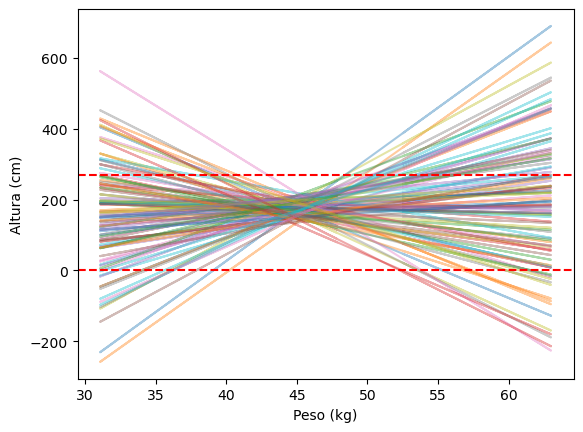

In [18]:
# Simulación previa predictiva
N = 100
w = np.linspace(
    datos_altura_adultos["weight"].min(),
    datos_altura_adultos["weight"].max(),
)
w = datos_altura_adultos["weight"].values
w_bar = w.mean()
muestras_alpha = stats.norm.rvs(loc=170, scale=20, size=N)
muestras_beta = stats.norm.rvs(loc=0, scale=10, size=N)
muestras_mu = muestras_alpha + muestras_beta * (w - w_bar).reshape(-1, 1)
plt.plot(datos_altura_adultos["weight"], muestras_mu, alpha=0.4)
plt.axhline(y=0, color="red", linestyle="--")
plt.axhline(y=270, color="red", linestyle="--")
plt.xlabel("Peso (kg)")
plt.ylabel("Altura (cm)")

Observamos que usando estas previas, las la altura promedio puede llegar a tomar valores bastante extremos para valores normales del peso. Podemos hacer algo mejor.

De la gráfica de puntos, observamos que la relación entre la altura y el peso es positiva. Una manera común de restringir un parámetro a que sea positivo es usando la distribución $\text{Log-Normal}$. Si definimos $\beta$ como $\text{Log-Normal}(0, 1)$, significa que el logaritmo de $\beta$ tiene una distribución $\text{Normal}(0, 1)$:

$$
\beta \sim \text{Log-Normal}(0, 1)
$$

In [19]:
# Densidad lognormal
stats.lognorm?

Signature:       stats.lognorm(*args, **kwds)
Type:            lognorm_gen
String form:     <scipy.stats._continuous_distns.lognorm_gen object at 0x0000018D038805B0>
File:            c:\users\esjim\anaconda3\envs\mebo2024_v4\lib\site-packages\scipy\stats\_continuous_distns.py
Docstring:      
A lognormal continuous random variable.

As an instance of the `rv_continuous` class, `lognorm` object inherits from it
a collection of generic methods (see below for the full list),
and completes them with details specific for this particular distribution.

Methods
-------
rvs(s, loc=0, scale=1, size=1, random_state=None)
    Random variates.
pdf(x, s, loc=0, scale=1)
    Probability density function.
logpdf(x, s, loc=0, scale=1)
    Log of the probability density function.
cdf(x, s, loc=0, scale=1)
    Cumulative distribution function.
logcdf(x, s, loc=0, scale=1)
    Log of the cumulative distribution function.
sf(x, s, loc=0, scale=1)
    Survival function  (also defined as ``1 - cdf``, but `s

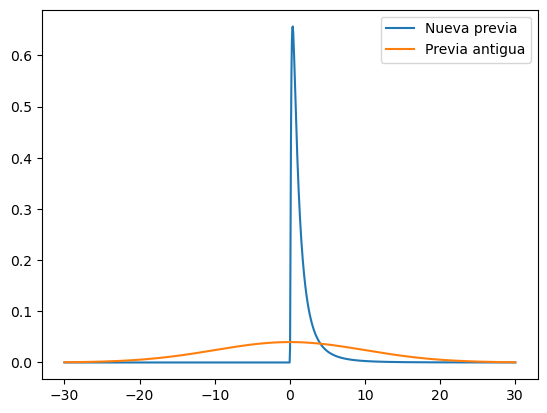

In [23]:
x = np.linspace(-30, 30, 1000)
plt.plot(x, stats.lognorm.pdf(x, loc=0, s=1), label="Nueva previa")
plt.plot(x, stats.norm.pdf(x, loc=0, scale=10), label="Previa antigua")
plt.legend()

Text(0, 0.5, 'Altura (cm)')

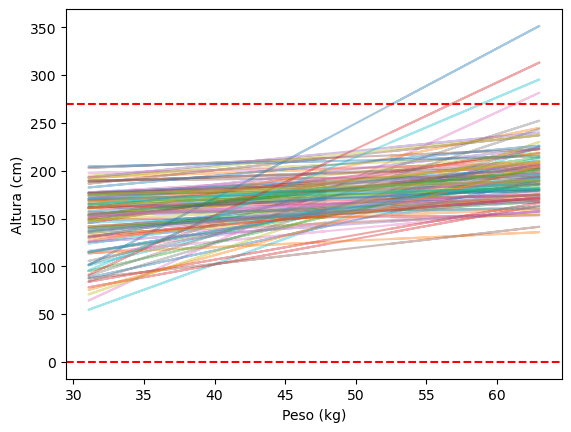

In [26]:
# Simulación previa predictiva
N = 100
w = np.linspace(
    datos_altura_adultos["weight"].min(),
    datos_altura_adultos["weight"].max(),
)
w = datos_altura_adultos["weight"].values
w_bar = w.mean()
muestras_alpha = stats.norm.rvs(loc=170, scale=20, size=N)
muestras_beta = stats.lognorm.rvs(loc=0, s=1, size=N)
muestras_mu = muestras_alpha + muestras_beta * (w - w_bar).reshape(-1, 1)
plt.plot(datos_altura_adultos["weight"], muestras_mu, alpha=0.4)
plt.axhline(y=0, color="red", linestyle="--")
plt.axhline(y=270, color="red", linestyle="--")
plt.xlabel("Peso (kg)")
plt.ylabel("Altura (cm)")

¡Esto se ve mucho mejor!

De forma que nuestro modelo completo es:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta(w_i - \bar{w}) \\
\alpha & \sim & \text{Normal}(170, 20) \\
\beta & \sim & \text{Log-Normal}(0, 1) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

**Estimemos la distribución posterior usando MCMC:**

In [27]:
# Importar pymc
import pymc as pm
# Importar arviz
import arviz as az

In [29]:
# Peso
w = datos_altura_adultos["weight"].values
# Peso promedio
w_bar = w.mean()
# Modelo
with pm.Model() as height_model_predictive:
    # Sigma
    sigma = pm.Uniform("sigma", 0, 50)
    # a y b
    alpha = pm.Normal("alpha", mu=170, sigma=20)
    beta = pm.Lognormal("beta", mu=0, tau=1)
    # Mu
    mu = alpha + beta * (w - w_bar)
    # Altura
    altura = pm.Normal(
        "altura",
        mu=mu,
        sigma=sigma,
        observed=datos_altura_adultos["height"].values
    )
    # Muestreo
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [30]:
# Distribución posterior de los parámetros
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,154.601,0.277,154.088,155.107,0.004,0.003,6047.0,3176.0,1.0
sigma,5.102,0.190,4.753,5.455,0.002,0.002,5966.0,2946.0,1.0
beta,0.903,0.043,0.822,0.982,0.001,0.000,6211.0,3130.0,1.0


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

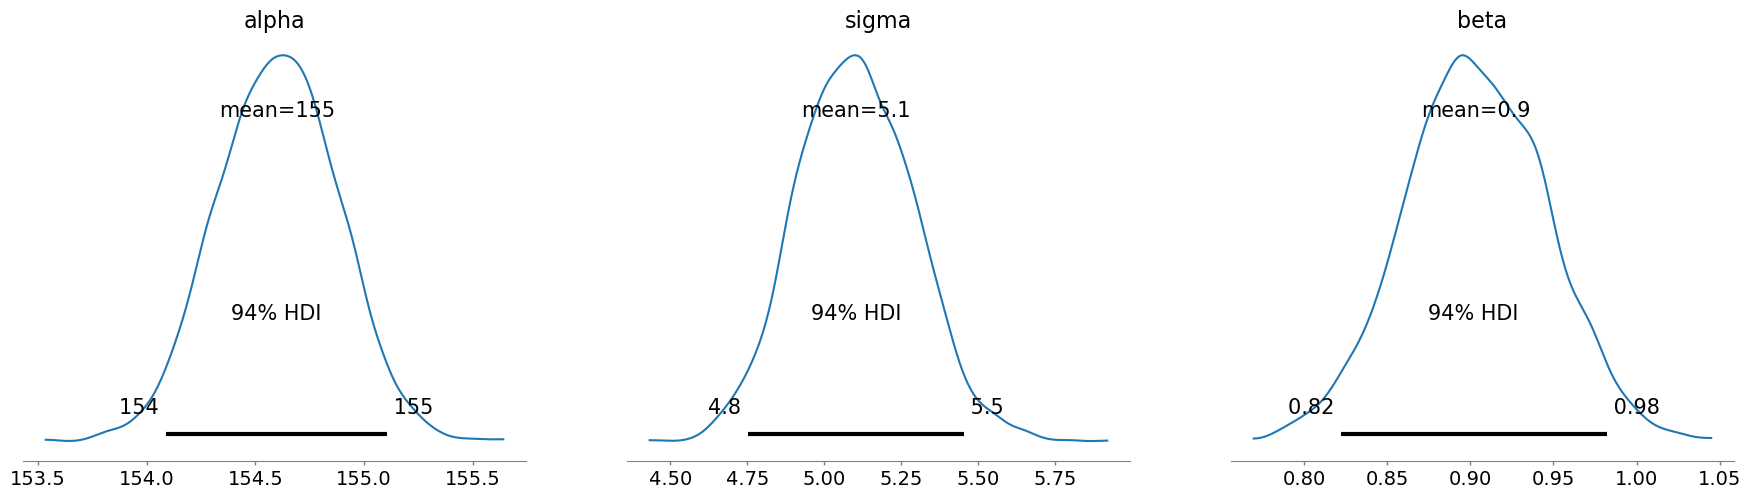

In [31]:
# az.plot_posterior
az.plot_posterior(idata)

¿Qué podemos decir?

- La altura promedio, al peso promedio está alrededor de 155 cm.

- Por cada 1 kg adicional, se espera que la altura sea ~0.90 cm mayor.

- El 94% de la probabilidad de la distribución posterior de $\beta$ yace entre 0.82 y 0.98, lo que indica que valores cercanos a cero y valores mayores a uno, no son compatibles con los datos y el modelo.

**Predicciones con la posterior**

La idea principal de este modelo es hacer predicciones con él. Veamos como hacerlo.

Lo primero que podríamos hacer es tomar el promedio de las muestras de $\alpha$ y $\beta$, y graficar la relación promedio:

In [32]:
# Objeto de muestreo
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Text(0, 0.5, 'Altura (cm)')

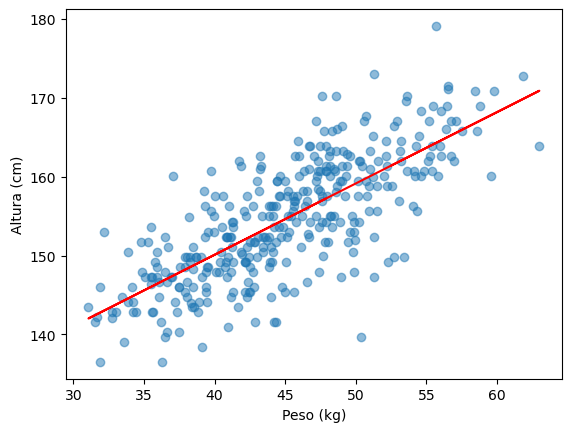

In [35]:
# Relación promedio
alpha_avg = idata.posterior["alpha"].mean().item(0)
beta_avg = idata.posterior["beta"].mean().item(0)
mu_avg = alpha_avg + beta_avg * (w - w_bar)
plt.scatter(
    datos_altura_adultos["weight"],
    datos_altura_adultos["height"],
    alpha=0.5
)
plt.plot(w, mu_avg, color="red")
plt.xlabel("Peso (kg)")
plt.ylabel("Altura (cm)")

Esta relación promedio (al tratarse el modelo de una normal) no es más que la línea promedio; la línea más plausible en el conjunto infinito de lineas en la distribución posterior.

Sin embargo, a esto le podemos añadir la incertidumbre alrededor de la media, graficando algunas líneas muestreadas de la posterior:

In [36]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [37]:
posterior_df = idata.posterior.to_dataframe()
posterior_df.head()

alpha     sigma      beta
chain draw                                
0     0     154.291323  4.977002  0.893618
      1     154.319326  5.199999  0.901639
      2     154.948047  4.976443  0.937551
      3     154.936773  4.754216  0.986437
      4     154.741065  5.216760  0.891380

In [39]:
posterior_df.sample?

Signature:
posterior_df.sample(
    n: 'int | None' = None,
    frac: 'float | None' = None,
    replace: 'bool_t' = False,
    weights=None,
    random_state: 'RandomState | None' = None,
    axis: 'Axis | None' = None,
    ignore_index: 'bool_t' = False,
) -> 'Self'
Docstring:
Return a random sample of items from an axis of object.

You can use `random_state` for reproducibility.

Parameters
----------
n : int, optional
    Number of items from axis to return. Cannot be used with `frac`.
    Default = 1 if `frac` = None.
frac : float, optional
    Fraction of axis items to return. Cannot be used with `n`.
replace : bool, default False
    Allow or disallow sampling of the same row more than once.
weights : str or ndarray-like, optional
    Default 'None' results in equal probability weighting.
    If passed a Series, will align with target object on index. Index
    values in weights not found in sampled object will be ignored and
    index values in sampled object not in weights wil

Text(0, 0.5, 'Altura (cm)')

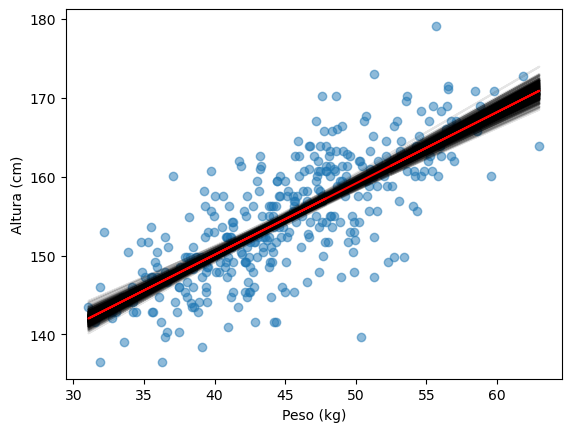

In [41]:
# Algunas muestras de la posterior
muestras_post = posterior_df.sample(500)
post_mu = muestras_post["alpha"].values + muestras_post["beta"].values * (w - w_bar).reshape(-1, 1)
plt.scatter(
    datos_altura_adultos["weight"],
    datos_altura_adultos["height"],
    alpha=0.5
)
plt.plot(w, post_mu, color="k", alpha=0.1)
plt.plot(w, mu_avg, color="red")
plt.xlabel("Peso (kg)")
plt.ylabel("Altura (cm)")

Una pregunta que nos podríamos hacer es, ¿Cuánto es la altura promedio de una persona de 60kg?. Una vez más, podemos usar las muestras de la posterior para responder a esta pregunta:

In [43]:
# mu at 60
mu_at_60 = posterior_df["alpha"].values + posterior_df["beta"].values * (60 - w_bar)
mu_at_60.shape

(4000,)

In [45]:
mu_at_60.mean(), np.percentile(mu_at_60, 3), np.percentile(mu_at_60, 97)

(168.15948986799876, 166.81449952855843, 169.49521511465952)

<Axes: >

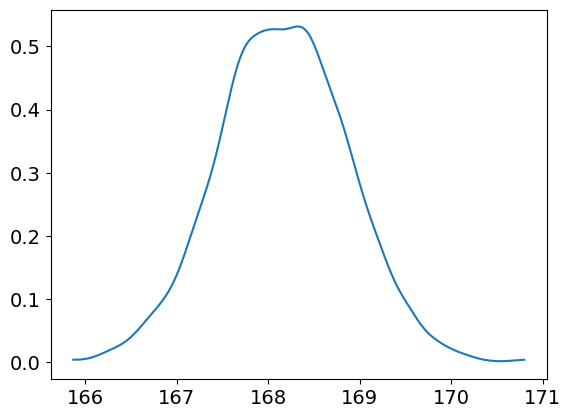

In [46]:
# kde plot
az.plot_kde(mu_at_60)

In [ ]:
# az.hdi


La altura promedio (89%) está entre 167 cm y 169 cm (condicional al modelo y los datos), dado que el peso es 60 kg.

**¿Y $\sigma$?**

Recordemos que el modelo de la altura era:

$$
h_i \sim \text{Normal}(\mu_i, \sigma)
$$

y aunque hasta ahora solo hemos hablado de $\mu$, la variación fuera del promedio es bastante importante.

Primero, generamos las muestras de predicción. Como antes, podríamos hacerlo a mano, pero pymc lo puede hacer por nosotros:

In [48]:
# Peso
w = datos_altura_adultos["weight"].values
# Peso promedio
w_bar = w.mean()
# Modelo
with pm.Model() as height_model_predictive:
    # Sigma
    sigma = pm.Uniform("sigma", 0, 50)
    # a y b
    alpha = pm.Normal("alpha", mu=170, sigma=20)
    beta = pm.Lognormal("beta", mu=0, tau=1)
    # Mu
    mu = pm.Deterministic("mu", alpha + beta * (w - w_bar))
    # Altura
    altura = pm.Normal(
        "altura",
        mu=mu,
        sigma=sigma,
        observed=datos_altura_adultos["height"].values
    )
    # Muestreo
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [49]:
posterior_df = idata.posterior.to_dataframe()
posterior_df.head()

alpha    sigma      beta          mu
chain draw mu_dim_0                                           
0     0    0         154.649659  4.96518  0.860655  157.089720
           1         154.649659  4.96518  0.860655  147.330065
           2         154.649659  4.96518  0.860655  143.353005
           3         154.649659  4.96518  0.860655  161.579162
           4         154.649659  4.96518  0.860655  151.453519

In [50]:
# Generamos muestras predictivas de la posterior
with height_model_predictive:
    height_post_pred = pm.sample_posterior_predictive(idata)

Sampling: [altura]


In [53]:
height_post_pred.posterior_predictive

<xarray.Dataset> Size: 11MB
Dimensions:       (chain: 4, draw: 1000, altura_dim_2: 352)
Coordinates:
  * chain         (chain) int32 16B 0 1 2 3
  * draw          (draw) int32 4kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * altura_dim_2  (altura_dim_2) int32 1kB 0 1 2 3 4 5 ... 347 348 349 350 351
Data variables:
    altura        (chain, draw, altura_dim_2) float64 11MB 153.1 154.8 ... 163.4
Attributes:
    created_at:                 2024-11-15T01:19:30.652055
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

In [57]:
post_mu.shape

(352, 500)

c:\Users\esjim\anaconda3\envs\mebo2024_v4\lib\site-packages\arviz\plots\hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


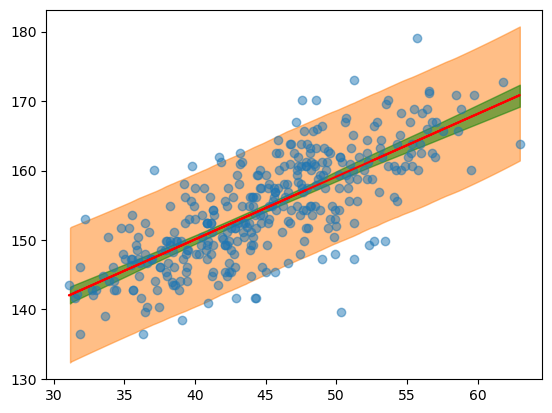

In [59]:
# Intervalo de credibilidad de la altura
az.plot_hdi(w, height_post_pred.posterior_predictive["altura"], hdi_prob=0.94)
# Intervalo de credibilidad de la altura promedio
az.plot_hdi(w, post_mu.T, color="green", hdi_prob=0.94)
# Línea promedio
plt.plot(w, mu_avg, color="red")
# Nube de puntos
plt.scatter(
    datos_altura_adultos["weight"],
    datos_altura_adultos["height"],
    alpha=0.5
)

## 2. Comentarios finales

Como en el módulo 1, podemos usar este mismo tipo de modelos lineales en los parámetros para representar relaciones no lineales entre los datos. Podemos usar polinomios, o cualquier otro tipo de representaciones no lineales que nos interese.

Por ejemplo, si consideraramos todos los datos, incluyendo los de los niños:

Text(0, 0.5, 'Height (cm)')

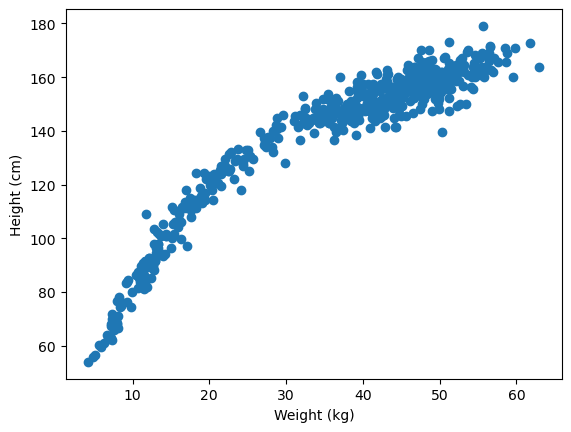

In [60]:
# Scatter plot
plt.scatter(datos_altura["weight"], datos_altura["height"])
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")

Observamos una relación cúbica. **Tarea**

**Ayuda**. Estandarizar el peso antes.

# Anuncios

## 1. Quiz tema 8 el martes 19 de nov.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>